In this notebook, we create a trading strategy that will later be fed through the bcktst package (see part 2).  
We use PADD oil storage data provided by the EIA to predict WTI prices.  
To refine our prediction, we use the Weighted Majority Algorithm using each PADD as an expert.

[PADD]:https://en.wikipedia.org/wiki/Petroleum_Administration_for_Defense_Districts



# Backtest example





In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Data

In [2]:
start_date = '2016-01-04'
end_date = '2018-10-01'

## USA Crude oil storage

[EIA]:https://www.eia.gov/
[PADD]:https://en.wikipedia.org/wiki/Petroleum_Administration_for_Defense_Districts

Crude oil storage data is taken from the [EIA][EIA]. They publish weekly data [PADD] by PADD for crude oil and products.

In [3]:
eia = pd.read_csv('data/eia.csv', index_col=0, converters={0: pd.to_datetime})[start_date: end_date]
eia.index = eia.index + pd.Timedelta(days=5) # Friday data is made publicly available teh following Wed
eia.head()

PADD_1    PADD_2    PADD_3   PADD_4   PADD_5
Date                                                     
2016-01-13  16231.0  145329.0  215883.0  19118.0  54631.0
2016-01-20  15777.0  144092.0  221089.0  19373.0  54838.0
2016-01-27  15696.0  144035.0  228642.0  19547.0  55632.0
2016-02-03  16341.0  145255.0  232260.0  19582.0  57907.0
2016-02-10  16494.0  146907.0  231002.0  19078.0  57194.0

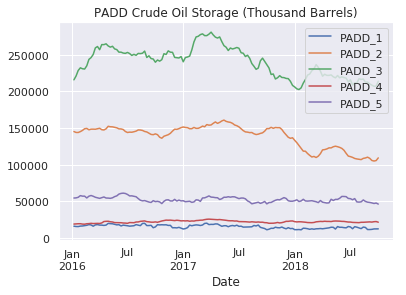

In [4]:
eia.plot(title='PADD Crude Oil Storage (Thousand Barrels)');

## Prices

[CME]:https://www.quandl.com/data/CME-Chicago-Mercantile-Exchange-Futures-Data
        
Prices are obtained from the [CME][CME] on Quandl. Prices used here are roll adjusted 3 days before expiry of their respective futures trading: buy the next month, sell the onw you own. 

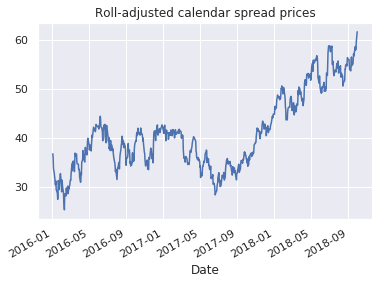

In [5]:
prices = pd.read_csv('data/wti_ra.csv', index_col=0, converters={0: pd.to_datetime})[start_date: end_date]
calendar_spread =  prices['WTI_1m_ra'] # prices['WTI_6m_ra'] 
calendar_spread.plot(title='Roll-adjusted calendar spread prices');

# Weighted Majority Algorithm

In [6]:
def align_yaxis(ax1, v1, ax2, v2):
    """
    This is a plotting util to align axes in a plt plot.
    adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1-y2))
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(miny+dy, maxy+dy)

In [7]:
def ewa_weights(X_experts: pd.DataFrame, y: pd.Series, gamma: float, loss: callable = np.abs, ret_init_weights=False):
    """
    Returns the exponential weights (as defined by the WM Algorithm) from a dataframe of experts' predictions.
    Note that predictions(y_hat) and true (y) must be aligned.

    :param X_experts: dataframe of experts' predictions (in columns)
    :param y: series of true
    :param gamma: parameter of trade-off between enthropy and instantaneous loss
    :param loss: loss function
    :param ret_init_weights: whether one wants to return initial weights
    :return: dataframe with predictions and weights
    """
    init_weight = 1 / X_experts.shape[1]
    out = init_weight * np.exp(- gamma * X_experts.apply(lambda s: loss(s - y)).cumsum())  # EWA weight calc
    out = out.apply(lambda r: r / r.sum(), axis=1)  # Normed
    if ret_init_weights:
        return out, init_weight
    return out

In [8]:
def get_trading_signal(votes, weights, censitary=False, min_weight_to_vote=None):
    """
    From expert votes and their individual weights, return the raw trading signal
    :param votes:
    :param weights:
    :param censitary:
    :param min_weight_to_vote: float. only taken in account if censitary==True
    :return:
    """
    if censitary:  # only weight "good farms"
        assert min_weight_to_vote is not None, 'must pass min_weight_to_vote if censitary==True'
        censitary_weights = weights.apply(lambda s: s.apply(lambda x: x if x >= min_weight_to_vote else 0))
        censitary_weights = censitary_weights.apply(lambda r: r / r.sum(), axis=1)
        weighted_votes = votes * censitary_weights
        return weighted_votes.sum(axis=1)

    weighted_votes = votes * weights
    return weighted_votes.sum(axis=1)

We do not use the raw PADD storage directly. Instead, we use the WoW change and the 2Wo2W change for each PADD. This is more economically intuitive: what moves the market is the extra flow of oil on the market, not the absolute level in storage.

In [9]:
max_diff_period = 2  # if =3, 3Wo3W change would also be considered an expert.
experts = pd.DataFrame()
for d in range(1,max_diff_period+1):
    experts = pd.concat([experts, eia.diff(d).rename(lambda x: x + '_diff_{}'.format(d), axis=1)], axis=1)
experts = experts.iloc[max_diff_period:]
experts = experts.applymap(lambda x: np.sign(x))
experts.head()

PADD_1_diff_1  PADD_2_diff_1  PADD_3_diff_1  PADD_4_diff_1  \
Date                                                                     
2016-01-27           -1.0           -1.0            1.0            1.0   
2016-02-03            1.0            1.0            1.0            1.0   
2016-02-10            1.0            1.0           -1.0           -1.0   
2016-02-17            1.0            1.0           -1.0           -1.0   
2016-02-24            1.0            1.0            1.0            1.0   

            PADD_5_diff_1  PADD_1_diff_2  PADD_2_diff_2  PADD_3_diff_2  \
Date                                                                     
2016-01-27            1.0           -1.0           -1.0            1.0   
2016-02-03            1.0            1.0            1.0            1.0   
2016-02-10           -1.0            1.0            1.0            1.0   
2016-02-17           -1.0            1.0            1.0           -1.0   
2016-02-24           -1.0            1.0            1.0            1.0   

            PADD_4_diff_2  PADD_5_diff_2  
Date                                      
2016-01-27            1.0            1.0  
2016-02-03            1.0            1.0  
2016-02-10           -1.0            1.0  
2016-02-17           -1.0           -1.0  
2016-02-24            1.0           -1.0

We try to predict the direction of change in prices at a 2 weeks horizon. Oil movements take time to hit the market.

In [10]:
h = 2  # horizon
y = calendar_spread.resample('D').ffill().reindex(eia.index)  # ffill to avoid hindsight
y = y.diff(h).apply(lambda x: np.sign(x)).reindex(experts.index)  # convert to +1/-1 for increases/decreases
y.head()

Date
2016-01-27    1.0
2016-02-03    1.0
2016-02-10   -1.0
2016-02-17   -1.0
2016-02-24    1.0
Freq: W-WED, Name: WTI_1m_ra, dtype: float64

In most implementation of the WMA, gamma (the "learning rate") decreases as time passes, assuming that the set of good experts is learned. We here fix gamma. This is to allow changes in the set of good experts (i.e. PADD1 being a good expert last week does not mean it'll be the best expert a couple of month from now).

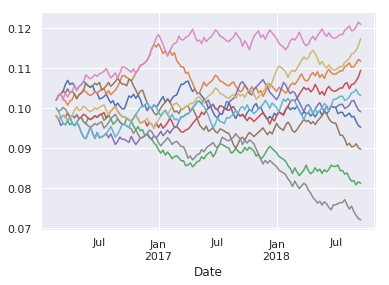

In [11]:
gamma = 0.01
weights = ewa_weights(experts.shift(h), y, gamma=gamma).iloc[h+d:-h]
weights.plot(legend=False);

There are a few parameters:
* **min_weight_to_vote**: experts with weights below a threshold are not allowed to vote. 
* **min_signal_to_trade**: if the overall vote of expert is too close to zero, they are not agreeing. We do not trade on mixed signal

In [12]:
votes = experts.iloc[h+d:-h]
init_weight = 1 / experts.shape[1]
min_weight_to_vote = .05* init_weight
min_signal_to_trade = 0.1
trading_signal_raw = get_trading_signal(votes, weights, censitary=True, min_weight_to_vote=min_weight_to_vote)
trading_signal = trading_signal_raw.apply(lambda x: np.sign(x) if abs(x) >= min_signal_to_trade else 0)
trading_signal_bool = trading_signal != 0
trading_signal_when_trading = trading_signal[trading_signal_bool]
realized = y.shift(-h).reindex(trading_signal.index)
realized_when_trading = realized[trading_signal_bool]

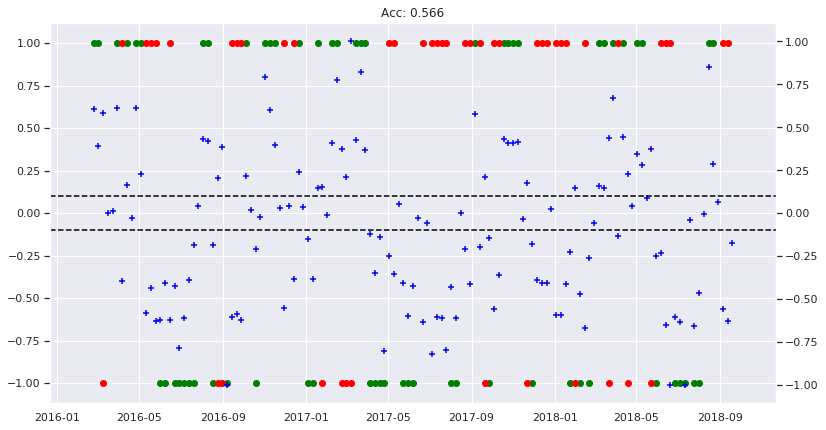

In [13]:
fig, ax1 = plt.subplots(figsize=(13, 7))
ax2 = ax1.twinx()
ax2.scatter(trading_signal_raw.index, trading_signal_raw, marker='+', c='blue')
well_predicted_bool = ((trading_signal_when_trading - realized_when_trading) == 0)
ax1.scatter(realized_when_trading[well_predicted_bool].index, realized_when_trading[well_predicted_bool], c='green')
ax1.scatter(realized_when_trading[~well_predicted_bool].index, realized_when_trading[~well_predicted_bool], c='red')
ax2.axhline(min_signal_to_trade, c='black', linestyle='dashed')
ax2.axhline(-min_signal_to_trade, c='black', linestyle='dashed')
plt.title('Acc: {}'.format(round(well_predicted_bool.mean(), 3)))
plt.grid()
align_yaxis(ax1, 0, ax2, 0)

At y=1 and y=-1 are our predictions, drawn as red and green dots. Green means we were right, red means we mis-predicted. The blue crosses are the votes of our experts. If they are outside the dashed line "tunnel" (representing min_signal_to_trade), then we made a prediction and thus the cross has a corresponding dot.

We achieve almost 57% accuracy on the market. Is that enough to make money? In bcktst part 2, we backtest this strategy and determine the return if someonehad implemented it.

In [14]:
trading_signal.to_csv('data/trading_signal.csv')